
# How to beat terrorism efficiently: identification of set of key players in terrorist networks.

## GROUP 27.  Members:
* Abrate, Marco Pietro
* Bolón Brun, Natalie
* Kakavandy, Shahow  
* Park, Jangwon 

## PROJECT DESCRIPTION:
Proliferation of terrorism in recent years has led people to believe it as a real threat to their livelihood. Vital to the success of such terrorist organizations are the cohesiveness and ability to communicate efficiently within their respective terrorist networks. To make these networks vulnerable, identifying sources of such properties is an imperative mission and hence becomes the focus of this report. More technically, we seek to develop an appropriate methodology to evaluate the importance of each terrorist to the effectiveness of the network as a whole, and identify an optimal set of key terrorists that one should target in order to debilitate it.



# PART I - FRAGMENTATION OF THE NETWORK

# Initial Information: 

This notebook contains initial data exploration about the network as well as analysis for the fragmentation task. For comments on the results or further details about the reasoning behind the different sections, please refer to the report.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import gridspec


import pygsp as pg
import networkx as nx

# import our own functions
from data_exploration_functions import get_true_labels, find_components, find_largest_component, \
give_names_tonodes_dates_based, num_nodes, connected_graph, compute_shortest_path_lengths
from fragmentation_measures import num_disconnected_components, F_measure, information_entropy, Fd_measure
from optimization_algorithms import find_key_terrorists_fragmentation, compute_objective

#import random


# Extracting Terrorist Names from Nodes

Load original network and get unique ID for each terrorist

In [2]:
A = np.load('adjacency.npy')

# get the largest component
A, size = find_largest_component(find_components(A))

n_nodes = size
n_edges = np.count_nonzero(A) / 2

# get terrorist names for each node
names, A, name_dict = give_names_tonodes_dates_based(A)

# get relation label for each node
labels = get_true_labels(A)

## Graph Inversion

In this section we seek to invert the graph yielding a structure that represents terrorists as nodes and relations between them as edges. This structure is prefered among the original one as it eases the interpretation of results given the nature of the purpose of the project.

Number of unique terrorist: 244


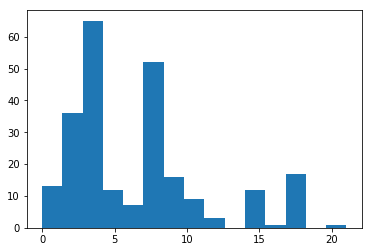

In [3]:
# Number of unique terrorists
num_terrorist = len(name_dict.keys())
print("Number of unique terrorist: {n:}".format(n=num_terrorist))

# Array of terrorist names 
all_names = np.array(list(name_dict.keys()))

# Initialize inverted adjacency matrix. Symmetric and unweighted by default.
A_inverted = np.zeros((num_terrorist, num_terrorist))
A_relations = np.zeros((num_terrorist, num_terrorist))

for n in range(n_nodes):
    temp = []
    for d, name in enumerate(list(name_dict.keys())):
        if n in list(name_dict.values())[d]:
            # collect all terrorist names that correspond to node n: will ALWAYS be at most length 2
            temp.append(list([name]))

    for k in range(len(temp)):
        for j in range(k, len(temp)):
            idx = np.where(all_names == temp[k])[0][0]
            idx2 = np.where(all_names == temp[j])[0][0]
            
            # create an edge between all terrorists that belonged to the same node in original graph
            A_inverted[idx,idx2] = 1
            A_inverted[idx2,idx] = 1
            
            # create a matrix which stores corresponding relations between terrorists             
            A_relations[idx,idx2] = int(labels[n])
            A_relations[idx2,idx] = int(labels[n])
            
plt.hist(np.sum(A_inverted,axis=1), bins=15)
plt.show()

In the inverted network we encounter 244 unique terrorists. The histogram shows the distribution of degrees along the inverted network. We can see the bast majority of the nodes have a degree lower than 10 while just a few achieve a higher degree of connection. The maximum degree of connectivity is 21 achieved by only one node.

### Largest Component of Inverted Graph

In this section we look for the largest component on the new network. For the purpose of the project, we are not interested in working with disconnected components. For further details, refer to the report.

Number of disconnected components: 30


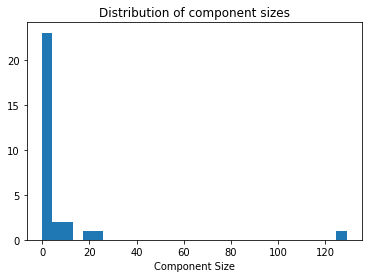

Size of inverted graph: 244
Size of largest component: 129


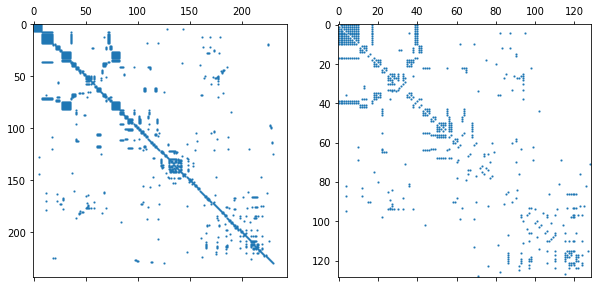

In [4]:
# Find the largest component
components = find_components(A_inverted)
largest_cc_inv, size = find_largest_component(components)

# Remove all-zero indices
zero_index = np.where(np.sum(largest_cc_inv, axis=0) == 0)[0]
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=0)
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=1)
relations_largest_cc = np.delete(A_relations, zero_index, axis=0)
relations_largest_cc = np.delete(relations_largest_cc, zero_index, axis=1)
names_largest_cc = np.delete(all_names, zero_index)
np.fill_diagonal(largest_cc_inv, 0)

print("Number of disconnected components: {d:}".format(d=len(components)))
deg_dist = []
for c in range(len(components)):
    deg_dist.append(num_nodes(components[c]))

plt.hist(deg_dist, bins=len(components))
plt.xlabel('Component Size')
plt.title('Distribution of component sizes')
plt.show()

print("Size of inverted graph: {s:}".format(s=num_terrorist))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax1.spy(A_inverted, markersize=1)

print("Size of largest component: {s:}".format(s=size))
ax2 = fig.add_subplot(122)
ax2.spy(largest_cc_inv, markersize=1)

The inverted network has a total of 30 components. Nevertheless a big group (13) are just isolated nodes. There is only one component of considerable size (~20 nodes). Further analysis on its discard is explained in the report.

In [5]:
# Visualize correct parsing on the nodes names. 

display = False
if display:
    for idx, name in enumerate(names):
        print(name)
        for i in range(A.shape[0]):
            if A[idx, i] == 1:
                print("\t"+str(names[i]))

In [6]:
def from_matrix_to_dict(mat):
    d = {}
    for index, value in np.ndenumerate(mat):
        d[index] = value
        
    return d

## Visualization of inverted network and largest component

/Users/nataliebolon/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


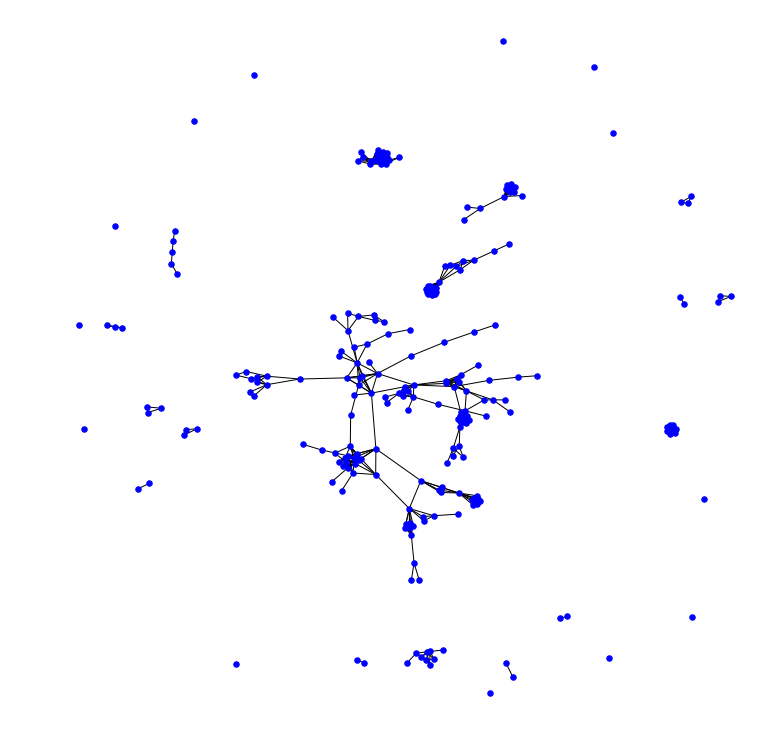

In [7]:
# Visualize inverted network
graph = nx.from_numpy_matrix(A_inverted)
d = from_matrix_to_dict(A_relations)
nx.set_edge_attributes(graph, d, 'relations')
plt.figure(1, figsize=(10, 10))
nx.draw(graph, pos=nx.spring_layout(graph), arrows=False, with_labels=False, node_size=30, node_color='b')
plt.show()

/Users/nataliebolon/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


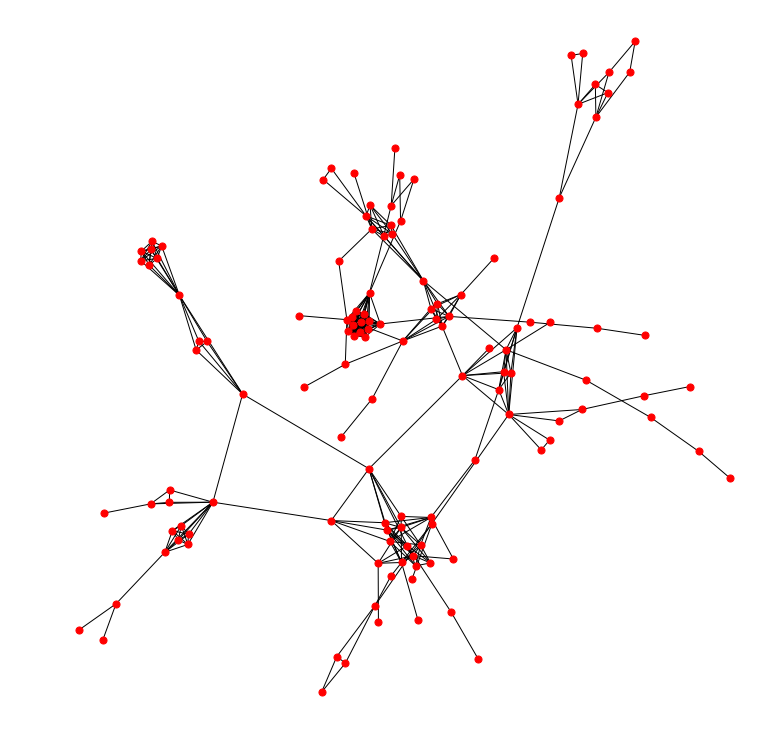

In [8]:
lcc_graph = nx.from_numpy_matrix(largest_cc_inv)
d = from_matrix_to_dict(relations_largest_cc)
nx.set_edge_attributes(lcc_graph, d, 'relations')
fig = plt.figure(1, figsize=(10, 10))
nx.draw(lcc_graph, pos=nx.spring_layout(lcc_graph), arrows=False, with_labels=False, node_size=50, node_color='r')
plt.show()

In [9]:
### GEPHI
nx.write_gml(lcc_graph, 'gephi/lcc_graph.gml')
nx.write_gml(graph, 'gephi/graph.gml')

# Identify Key Players for Fragmenting Network
In this section, we identify a set of key players that structurally destroys, or fragments, the network the most when removed. Metrics that help us evaluate this property include (all normalized except information entropy):
- count of number of disconnected components (+)
- F measure, count of number of pairs of nodes that are disconnected (+)
- Information entropy (+)
- Fd measure, modification of F measure which takes into account internal structure (+)

(+) = the higher, the more important that node is

Source: http://steveborgatti.com/papers/cmotkeyplayer.pdf

In [10]:
# compute value of different measures of fragmentation on the initial network
num_dis = num_disconnected_components(largest_cc_inv)

F = F_measure(largest_cc_inv)

entropy = information_entropy(largest_cc_inv)

Fd = Fd_measure(largest_cc_inv) # will display a progress bar

### Boxplots visualization of "fragmentation" measures

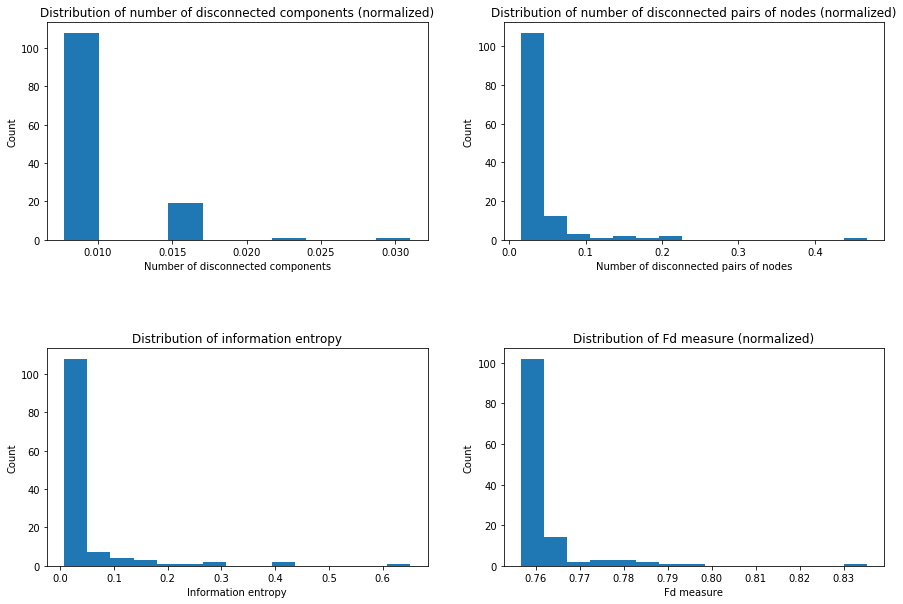

In [11]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax1.hist(num_dis, bins=10)
ax1.set_xlabel("Number of disconnected components")
ax1.set_ylabel("Count")
ax1.set_title("Distribution of number of disconnected components (normalized)")

ax2 = fig.add_subplot(222)
ax2.hist(F, bins=15)
ax2.set_xlabel("Number of disconnected pairs of nodes")
ax2.set_ylabel("Count")
ax2.set_title("Distribution of number of disconnected pairs of nodes (normalized)")

plt.subplots_adjust(hspace=0.5)

ax3 = fig.add_subplot(223)
ax3.hist(entropy, bins=15)
ax3.set_xlabel("Information entropy")
ax3.set_ylabel("Count")
ax3.set_title("Distribution of information entropy")

ax4 = fig.add_subplot(224)
ax4.hist(Fd, bins=15)
ax4.set_xlabel("Fd measure")
ax4.set_ylabel("Count")
ax4.set_title("Distribution of Fd measure (normalized)")
plt.show()

All measures explored in the network are increasing in value by relevance of the node. In all cases, we can see that the bast majority of the nodes are not relevant as they achieve low scores on the different measures. Nevertheless, in all cases we can encounter a small set of nodes or even a single one that differentiates from the rest by achieving a high score. 

### Determine if any of the above measures are positively correlated

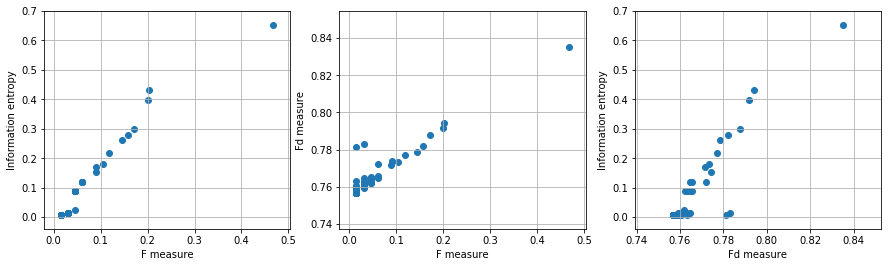

In [12]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.scatter(F, entropy)
ax1.set_xlabel("F measure")
ax1.set_ylabel("Information entropy")

ax2 = fig.add_subplot(132)
ax2.scatter(F, Fd)
ax2.set_xlabel("F measure")
ax2.set_ylabel("Fd measure")

ax3 = fig.add_subplot(133)
ax3.scatter(Fd, entropy)
ax3.set_xlabel("Fd measure")
ax3.set_ylabel("Information entropy")

ax1.grid()
ax2.grid()
ax3.grid()

# Identify Key Players for Information Flow


#### ATENTION: 
In this notebook, only **Fragmentation approach** is shown. For information flow please refer to notebook: **information_flow.ipynb**

In this section, centrality measures are computed but only fur later usage for comparison on results

In [13]:
# Degree centrality
degrees = np.sum(largest_cc_inv,axis=1) / (largest_cc_inv.shape[0]-1)

# convert adjacency matrix to networkx graph object
G = nx.from_numpy_matrix(largest_cc_inv)

# Closeness centrality
closeness = np.array(list(nx.closeness_centrality(G).values()))

# Betweenness centrality
between = np.array(list(nx.betweenness_centrality(G).values()))

# Greedy Optimization Algorithm

In this section an optimization algorithm is executed with the aim to find the **best set of nodes in the FRAGMENTATION approach**

In [14]:
# Find key terrorist for fragmenting the network. 
set_kt, objective = find_key_terrorists_fragmentation(largest_cc_inv, relations_largest_cc)

Number of key terrorists for fragmentation: 3
Indices of the key terrorists for fragmentation:  [38, 27, 22]
List of the names of the key terrorists for fragmentation: 
 ['/2005/09/08/04:39:17' 'Zawahiri' 'Zain_al-Abidin_Mohd_Hussein']


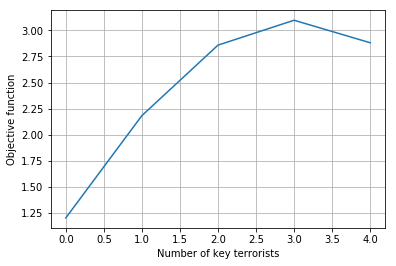

In [15]:
print("Number of key terrorists for fragmentation: {n:}".format(n=len(set_kt)-1))
print("Indices of the key terrorists for fragmentation: ", set_kt[:-1])
print("List of the names of the key terrorists for fragmentation: \n", names_largest_cc[set_kt[:-1]])

plt.plot(objective)
plt.xlabel("Number of key terrorists")
plt.ylabel("Objective function")
plt.grid()
plt.show()

# Results

Evalute the changes in the network when the optimal set is removed. Further comments on the results can be found in the report

In [16]:
# First, identify the top three terrorists based on three centrality measures for comparison purposes
k = 3
top_k_degrees = np.sort(degrees)[-k:]
top_k_between = np.sort(between)[-k:]
top_k_closeness = np.sort(closeness)[-k:]

list_degrees = []
list_between = []
list_closeness = []
for i in range(k):
    list_degrees.append(np.where(degrees == top_k_degrees[i])[0][0])
    list_between.append(np.where(between == top_k_between[i])[0][0])
    list_closeness.append(np.where(closeness == top_k_closeness[i])[0][0])
    
adj_degree = largest_cc_inv
adj_between = largest_cc_inv
adj_closeness = largest_cc_inv
adj_frag = largest_cc_inv

# Remove these top individuals found by centrality measures
adj_degree = np.delete(largest_cc_inv, np.array(list_degrees), axis=0)
adj_degree = np.delete(adj_degree, np.array(list_degrees), axis=1)

adj_between = np.delete(largest_cc_inv, list_between, axis=0)
adj_between = np.delete(adj_between, list_between, axis=1)

adj_closeness = np.delete(largest_cc_inv, list_closeness, axis=0)
adj_closeness = np.delete(adj_closeness, list_closeness, axis=1)

adj_frag = np.delete(largest_cc_inv, set_kt[:-1], axis=0)
adj_frag = np.delete(adj_frag, set_kt[:-1], axis=1)

In [17]:
def evaluate_fragmentation(original, adjacency):
    """
    Given original adjacency matrix, measure how fragmented "adjacency" is in comparison
    """
    # Number of disconnected components
    
    N = original.shape[0]
    components = find_components(adjacency)
    
    
    sum_Sk = 0
    numer = 0
    for i in range(len(components)):
        zero_index = np.where(np.sum(components[i], axis=0) == 0)[0]
        components[i] = np.delete(components[i], zero_index, axis=0)
        components[i] = np.delete(components[i], zero_index, axis=1)
        
        if len(components[i]) == 0: continue
            
        # F measure
        Sk = num_nodes(components[i])
        sum_Sk += (Sk * (Sk-1))
        
        # Information entropy
        numer += -(Sk / N)*np.log(Sk/N)
        
    Fmeasure = 1 - sum_Sk / (N*(N-1))
    
    # Number of edges cut
    E = np.count_nonzero(original) / 2
    edges_cut = np.count_nonzero(adjacency) / 2
    
    return Fmeasure, numer, len(components), (E - edges_cut)

# Compared to the original adjacency, measure how fragmented the new adjacency is
Fdegrees, ent_degrees, disc_degrees, edges_degrees = evaluate_fragmentation(largest_cc_inv, adj_degree)
Fbetween, ent_between, disc_between, edges_between = evaluate_fragmentation(largest_cc_inv, adj_between)
Fcloseness, ent_closeness, disc_closeness, edges_closeness = evaluate_fragmentation(largest_cc_inv, adj_closeness)
Ffrag, ent_frag, disc_frag, edges_frag = evaluate_fragmentation(largest_cc_inv, adj_frag)

In [18]:
print('              ','     F        | Information Entropy    | # disconnected components | Number of removed edges')

print('Degree        ', round(Fdegrees, 6), '           ', round(ent_degrees,6) , '                      ',\
      disc_degrees,'                          ', edges_degrees)

print('Betweenness c.', round(Fbetween, 6),  '           ', round(ent_between, 6), '                     ',\
      disc_between, '                          ', edges_between)

print('Closeness c.  ',round(Fcloseness, 6), '           ', round(ent_closeness, 6), '                     ',\
      disc_closeness, '                          ',edges_closeness)

print('Greedy Search ',round(Ffrag, 6),'           ', round(ent_frag, 6), '                      ',\
      disc_frag, '                          ',edges_frag)

                    F        | Information Entropy    | # disconnected components | Number of removed edges
Degree         0.279191             0.47826                        4                            43.0
Betweenness c. 0.497335             0.663679                       3                            25.0
Closeness c.   0.497335             0.663679                       3                            25.0
Greedy Search  0.691739             1.35473                        7                            32.0


In [19]:
F2 = F_measure(adj_frag)
IE2 = information_entropy(adj_frag)
Fd2 = Fd_measure(adj_frag)

##### COMMENT ON THE RESULTS:

The previous table shows different values of the metrics when a set of nodes is removed from the network. Four different sets of nodes are considered, each one of them generated as optimal in a different way (highest value of degree, betweenness centrality, closeness centrality or best score in the optimization task). 

The set found in the optimization task yields the best results as it fragments the network in 7 different subcomponents. By removing these nodes, 32 connections inside the netowork have been broken.

## Visual representation of results for comparison.

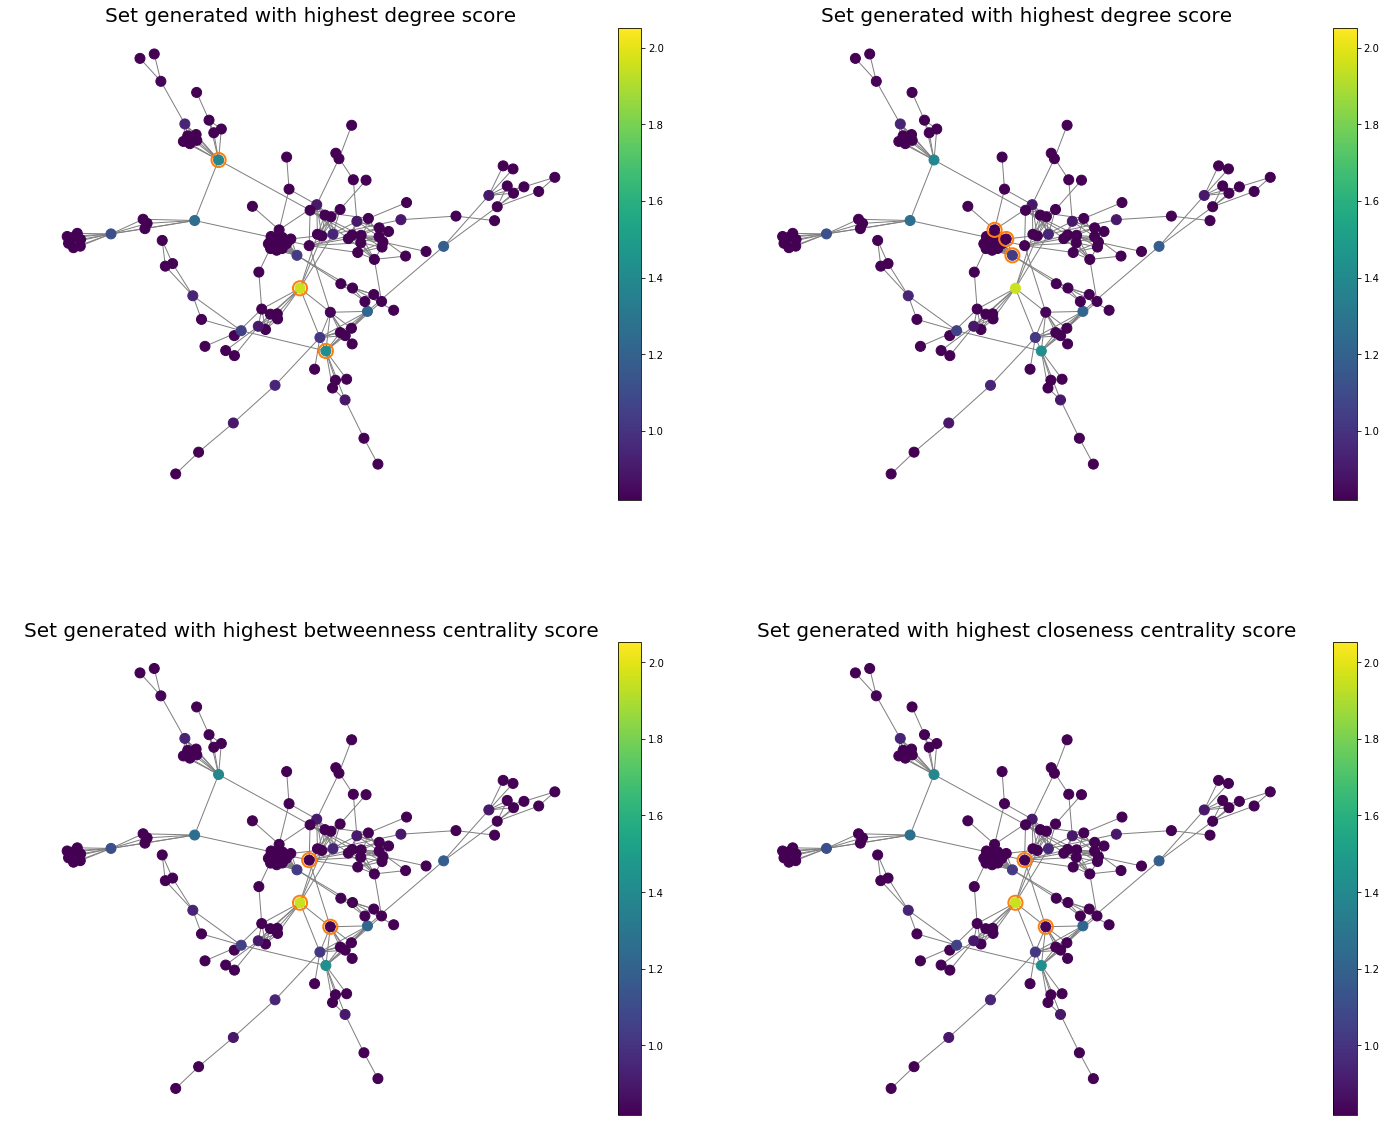

In [20]:
# Create pygsp graph for visualization
G_frag = pg.graphs.Graph(largest_cc_inv)
G_frag.set_coordinates('spring')

frag = F + entropy + Fd

# Highlight algorithm's findings
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 2,  hspace=0.3, wspace=0.05, left=0, right=0.97)
ax = plt.subplot(gs[0])
G_frag.plot_signal(frag, colorbar=True, ax=ax, highlight=set_kt[:-1])
title = r'Set generated with highest degree score'
_ = ax.set_title(title, fontdict={'fontsize': 20})
ax.set_axis_off()

# Highlight top individuals for degree centrality
#fig = plt.figure(figsize=(18, 21))
ax = plt.subplot(gs[1])
G_frag.plot_signal(frag, colorbar=True, ax=ax, highlight=list_degrees)
title = r'Set generated with highest degree score'
_ = ax.set_title(title, fontdict={'fontsize': 20})
ax.set_axis_off()

# Highlight top individuals for betweenness centrality
#fig = plt.figure(figsize=(18, 21))
ax = plt.subplot(gs[2])
G_frag.plot_signal(frag, colorbar=True, ax=ax, highlight=list_between)
title = r'Set generated with highest betweenness centrality score'
_ = ax.set_title(title, fontdict={'fontsize': 20})
ax.set_axis_off()

# Highlight top individuals for closeness centrality
#fig = plt.figure(figsize=(18, 21))
ax = plt.subplot(gs[3])
G_frag.plot_signal(frag, colorbar=True, ax=ax, highlight=list_closeness)
title = r'Set generated with highest closeness centrality score'
_ = ax.set_title(title, fontdict={'fontsize': 20})
ax.set_axis_off()

#### COMMENT ON THE RESULTS: 

The previous figure shows the network with the **set of nodes considered key highlighted** in orange. 

The colors in the different nodes represent its value scored in the "fragmentation" measure defined as objective function if the optimization algorithm. 

It can be seen that nodes with high degree, although being relevant for a big number of connections, will not be key in the fragmentation of the network, possibly because they involve non unique paths. 

On the other hand, nodes relevants for the fragmentation have also a high score on centrality measures. Given the meaning of these two measures, it is not surprising that both values are related.

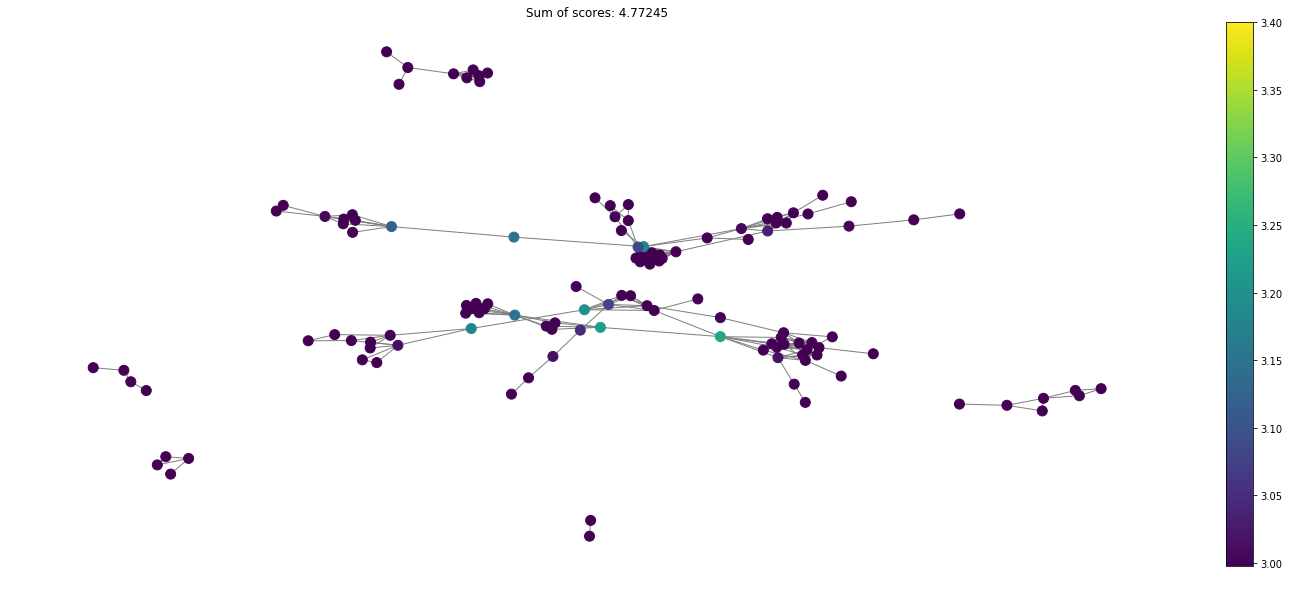

In [21]:
# Post-fragmentation network
G_frag2 = pg.graphs.Graph(adj_frag)
G_frag2.set_coordinates('spring')

frag2 = F2 + IE2 + Fd2

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 1,  hspace=0.3, wspace=0.05, left=0, right=0.97)
ax = plt.subplot(gs[0]) 
G_frag2.plot_signal(frag2, colorbar=True, ax=ax)
title = r'Sum of scores: {}'.format(round(np.sum(frag[set_kt[:-1]]), 5))
_ = ax.set_title(title)
ax.set_axis_off()

##### COMMENT ON THE RESULTS:

The plot shows the resulting network after the selected set of nodes has been removed. It yields 7 different subnetworks without any connection between them. The size of the components has been also reduced, generating 2 big hubs and 5 smaller networks. Nevertheless, the two big hubs are already much smaller than the initially connected net. Further analysis on the results is provided in the report.